In [15]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
# Loads the AMES housing Dataset
housing = fetch_openml(name="house_prices", as_frame=True)  # noqa

In [18]:
data = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['target'])

In [19]:
# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 


In [20]:
ordinal_cols = ['LotShape', 'Utilities', 'LandSlope', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'OverallQual']
discret_cols = ['Age', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'Fireplaces']
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'] 
target_cols = ['target']
nominal_cols = data.columns.difference(ordinal_cols+discret_cols+continuous_cols+target_cols+['Id'])

In [21]:
cols_to_remove = list(data.columns[((data.isnull().sum()/data.shape[0]*100) >= 80).values])
cols_to_remove

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [22]:
sparsity = pd.DataFrame()
sparsity['Value'] = data.apply(lambda column: column.mode().values[0])
sparsity['Percentage of value'] = data.apply(lambda column: round(column[column == column.mode().values[0]].count()/column.shape[0]*100,2))
cols_to_remove = list(set(cols_to_remove + list(sparsity[sparsity['Percentage of value'] >= 80].index)))
cols_to_remove

['Condition2',
 'PavedDrive',
 'Heating',
 'Street',
 'BsmtFinType2',
 'LowQualFinSF',
 'Functional',
 'MiscFeature',
 'BldgType',
 'LandSlope',
 'PoolArea',
 'Condition1',
 'GarageQual',
 'GarageCond',
 'BsmtCond',
 'CentralAir',
 'SaleType',
 'RoofMatl',
 'Electrical',
 'BsmtHalfBath',
 'Utilities',
 'ExterCond',
 'Fence',
 'KitchenAbvGr',
 '3SsnPorch',
 'ScreenPorch',
 'SaleCondition',
 'PoolQC',
 'EnclosedPorch',
 'LandContour',
 'BsmtFinSF2',
 'MiscVal',
 'Alley']

In [23]:
ordinal_cols = list(set(ordinal_cols)-set(cols_to_remove))
discret_cols = list(set(discret_cols)-set(cols_to_remove))
continuous_cols = list(set(continuous_cols)-set(cols_to_remove))
nominal_cols = list(set(nominal_cols)-set(cols_to_remove))

In [24]:
# Lot Shape
data.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)

# Exterior Quality
data.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Quality
data.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Exposure
data.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)

# Finished Basement 1 Rating
data.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Heating Quality and Condition
data.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Kitchen Quality
data.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Fireplace Quality
data.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Finish
data.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)

In [25]:
data[continuous_cols] = data[continuous_cols].astype('float64')
data[ordinal_cols] = data[ordinal_cols].astype('float64')
data[discret_cols] = data[discret_cols].astype('float64')
data.target = data.target.astype('float64');

In [26]:
data = data[data.columns.difference(cols_to_remove)]

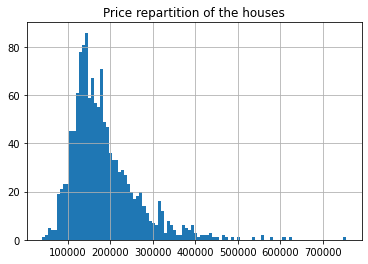

In [27]:
data.target.hist(bins=100)
plt.title('Price repartition of the houses')
plt.show()

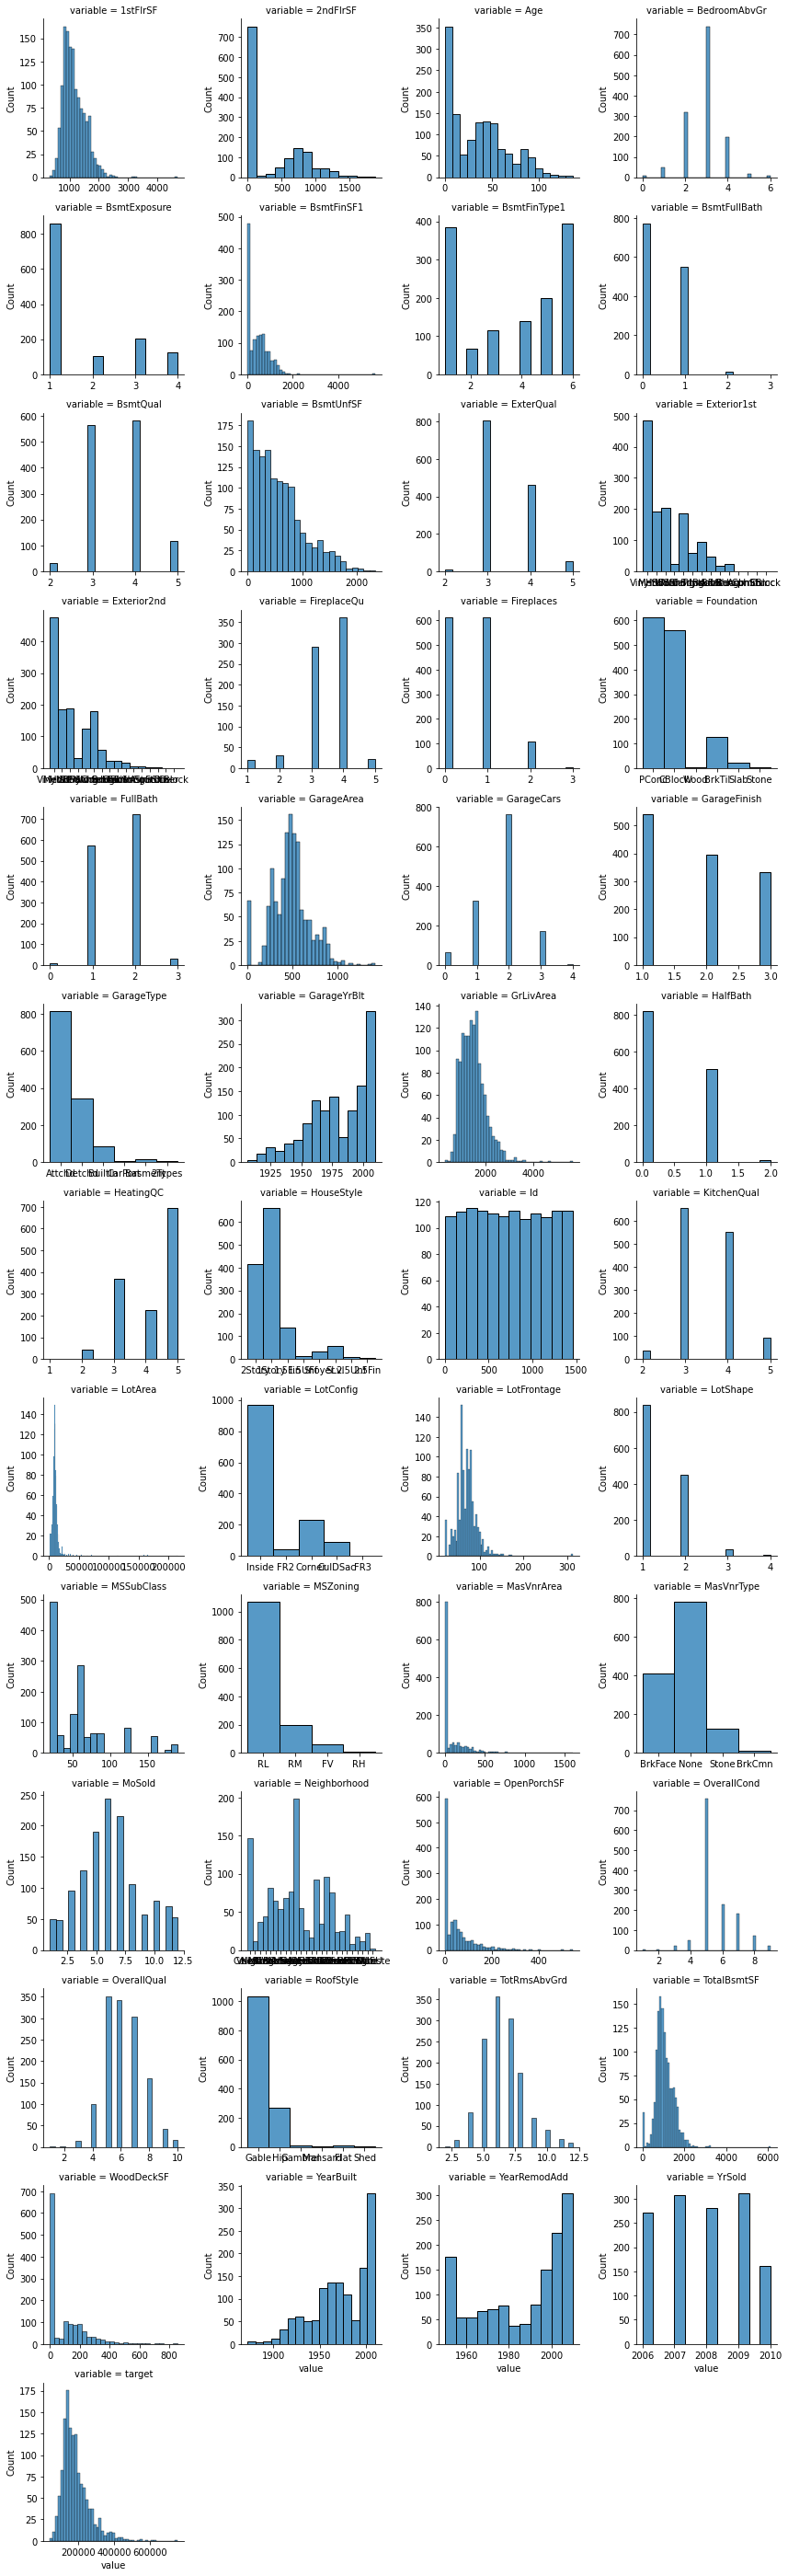

In [28]:
# Grid of distribution plots of all numerical features
f = pd.melt(data)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value')

In [29]:
data.target = data.target.astype('float64');

In [30]:
data['SumQual'] = data['OverallQual']+data['ExterQual']+data['KitchenQual']
data['MultQual'] = data['OverallQual']*data['ExterQual']*data['KitchenQual']
data['SumSF'] = (data['TotalBsmtSF']+data['1stFlrSF'])/2
data['MultSF'] = data['TotalBsmtSF']*data['1stFlrSF']

In [31]:
listcorr = data.corrwith(data['target']).abs().sort_values(ascending=False).head(50)
print(listcorr)

target          1.000000
MultQual        0.816044
SumQual         0.815613
OverallQual     0.794826
GrLivArea       0.708111
ExterQual       0.686069
KitchenQual     0.673814
GarageCars      0.652481
SumSF           0.641341
GarageArea      0.640069
BsmtQual        0.639685
TotalBsmtSF     0.615455
1stFlrSF        0.607699
FullBath        0.553145
TotRmsAbvGrd    0.544723
MultSF          0.532642
Age             0.518485
YearBuilt       0.518291
GarageFinish    0.504886
MasVnrArea      0.498631
YearRemodAdd    0.498347
GarageYrBlt     0.484702
Fireplaces      0.457557
HeatingQC       0.426783
BsmtFinSF1      0.369682
BsmtExposure    0.355893
LotFrontage     0.346440
OpenPorchSF     0.336385
WoodDeckSF      0.325117
FireplaceQu     0.314008
2ndFlrSF        0.308294
HalfBath        0.276590
LotArea         0.264694
BsmtFinType1    0.257118
LotShape        0.254357
BsmtUnfSF       0.241250
BsmtFullBath    0.210992
BedroomAbvGr    0.168481
OverallCond     0.102602
MoSold          0.053494


In [32]:
data.corr()

,1stFlrSF,2ndFlrSF,Age,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtFullBath,BsmtQual,BsmtUnfSF,ExterQual,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageFinish,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenQual,LotArea,LotFrontage,LotShape,MasVnrArea,MoSold,OpenPorchSF,OverallCond,OverallQual,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,target,SumQual,MultQual,SumSF,MultSF
1stFlrSF,1.000000,-0.215271,-0.279075,0.111823,0.319195,0.441012,0.202418,0.231755,0.367098,0.340392,0.407775,0.222711,0.408455,0.367660,0.500443,0.444292,0.297401,0.238681,0.558971,-0.126347,0.195892,0.398965,0.298922,0.452777,0.183890,0.357855,0.022413,0.220604,-0.162885,0.474516,0.401348,0.819400,0.246401,0.279255,0.232944,-0.007591,0.607699,0.485561,0.504569,0.946791,0.853246
2ndFlrSF,-0.215271,1.000000,-0.014761,0.513358,-0.135846,-0.149377,-0.142117,-0.176145,0.128252,0.006753,0.173828,0.041841,0.190620,0.424634,0.140816,0.184088,0.128485,0.071018,0.685097,0.616391,0.140067,0.176771,0.047389,0.082738,0.083062,0.182233,0.044459,0.210037,0.029261,0.290860,0.621168,-0.184007,0.084473,0.013588,0.135502,-0.027321,0.308294,0.260136,0.212583,-0.208092,-0.145290
Age,-0.279075,-0.014761,1.000000,0.068154,-0.283408,-0.233710,-0.331097,-0.168141,-0.718992,-0.167700,-0.593267,-0.085434,-0.129047,-0.465940,-0.490574,-0.550038,-0.580450,-0.827372,-0.204990,-0.226120,-0.452821,-0.548290,-0.009317,-0.129666,-0.224779,-0.310490,-0.017881,-0.206944,0.418188,-0.566821,-0.106687,-0.389959,-0.211271,-0.999038,-0.584942,0.063772,-0.518485,-0.625935,-0.600275,-0.354782,-0.299253
BedroomAbvGr,0.111823,0.513358,0.068154,1.000000,-0.128854,-0.124091,-0.152520,-0.166835,-0.058845,0.161001,-0.011120,-0.018057,0.116036,0.369379,0.075514,0.092740,-0.008022,-0.068975,0.520064,0.235432,-0.027818,0.001095,0.119703,0.273455,0.066752,0.104199,0.048634,0.092889,0.004509,0.099725,0.668382,0.027285,0.042757,-0.069116,-0.050913,-0.019045,0.168481,0.055323,0.014450,0.069746,0.037757
BsmtExposure,0.319195,-0.135846,-0.283408,-0.128854,1.000000,0.341712,0.292986,0.309043,0.322013,-0.074860,0.232143,0.111372,0.160670,0.104749,0.258941,0.254428,0.235705,0.237581,0.117144,-0.080827,0.125002,0.234972,0.236342,0.181945,0.158576,0.174570,0.010089,0.076200,-0.087978,0.263529,0.026889,0.326622,0.226722,0.280573,0.203367,-0.077011,0.355893,0.275133,0.284463,0.331917,0.297393
BsmtFinSF1,0.441012,-0.149377,-0.233710,-0.124091,0.341712,1.000000,0.681822,0.651088,0.253675,-0.489587,0.188574,0.007205,0.257541,0.030155,0.291840,0.213802,0.222198,0.138446,0.195629,0.000841,0.078905,0.220441,0.221868,0.229141,0.145730,0.273439,-0.027761,0.124863,-0.053444,0.221161,0.034297,0.517203,0.202696,0.234944,0.111074,0.018294,0.369682,0.235582,0.259917,0.505045,0.530378
BsmtFinType1,0.202418,-0.142117,-0.331097,-0.152520,0.292986,0.681822,1.000000,0.572248,0.256405,-0.480513,0.182533,-0.046827,0.103990,0.047236,0.188496,0.167194,0.193490,0.237417,0.023075,-0.007709,0.116808,0.203330,0.053353,0.063678,0.078917,0.175631,-0.039737,0.071785,-0.054948,0.161302,-0.071197,0.241803,0.146706,0.334470,0.182981,0.062910,0.257118,0.195197,0.198006,0.228924,0.192604
BsmtFullBath,0.231755,-0.176145,-0.168141,-0.166835,0.309043,0.651088,0.572248,1.000000,0.168489,-0.430231,0.103715,-0.008819,0.125940,-0.090147,0.168401,0.116772,0.153280,0.110810,0.019794,-0.035762,0.079239,0.146454,0.163186,0.097059,0.050335,0.082545,-0.031289,0.069585,-0.064396,0.092836,-0.065402,0.294677,0.170659,0.171690,0.106000,0.073749,0.210992,0.119939,0.133039,0.278253,0.246878
BsmtQual,0.367098,0.128252,-0.718992,-0.058845,0.322013,0.253675,0.256405,0.168489,1.000000,0.182522,0.642282,0.259814,0.206629,0.502673,0.478674,0.544429,0.536751,0.668447,0.373250,0.179629,0.422617,0.585801,0.073822,0.181534,0.212485,0.321681,0.014756,0.276801,-0.322222,0.663320,0.243719,0.443624,0.253924,0.719820,0.565851,-0.012273,0.639685,0.705251,0.698547,0.417880,0.369372
BsmtUnfSF,0.340392,0.006753,-0.167700,0.161001,-0.074860,-0.489

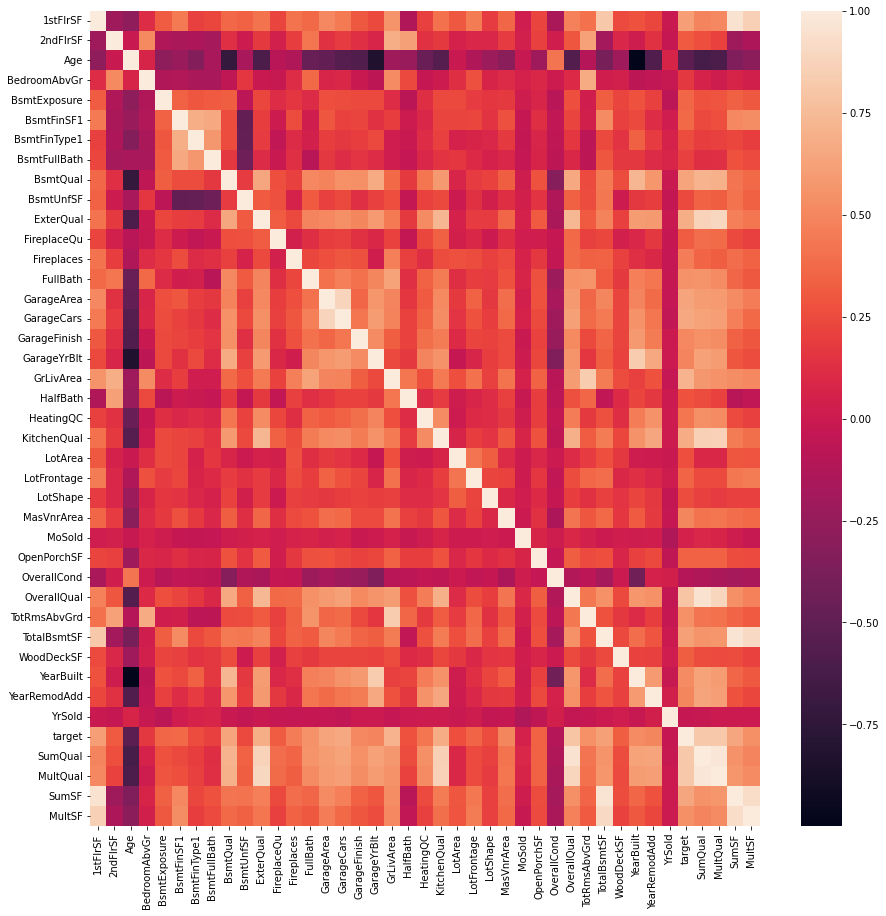

In [33]:
ax=sns.heatmap(data.corr(), xticklabels=True, yticklabels=True)
fig = plt.gcf()
# Modifie la taille du graphique
fig.set_size_inches(15,15)

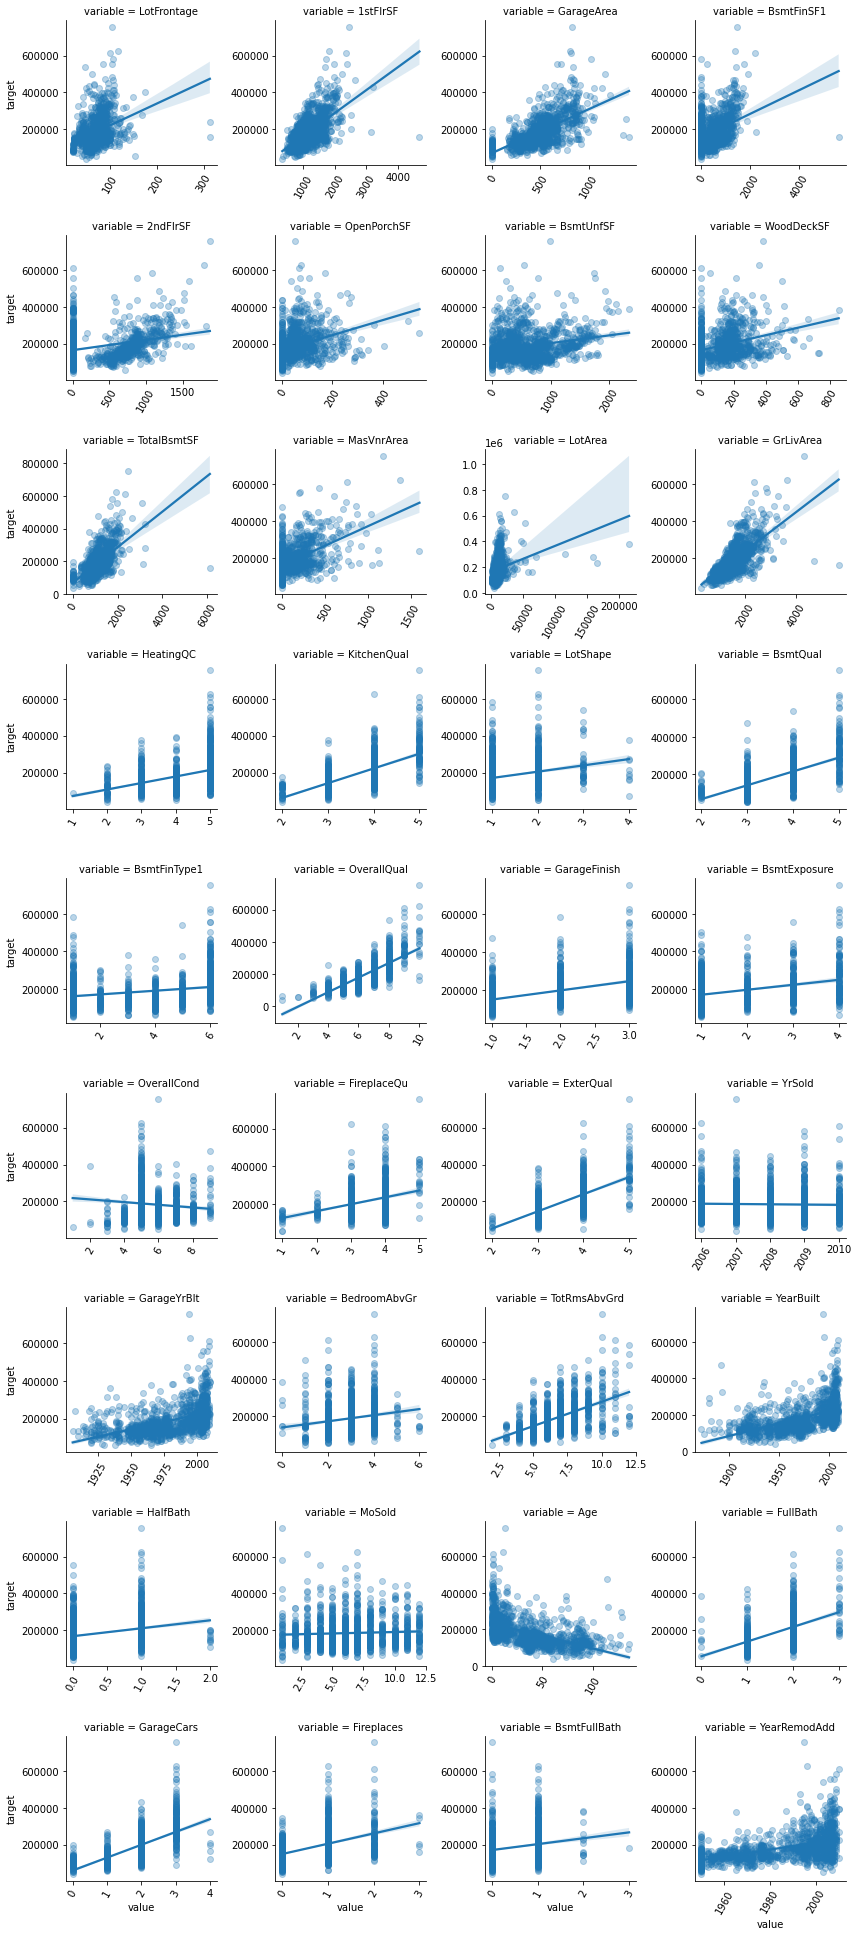

In [34]:
# Scatter plots of features against SalePrice
f = pd.melt(data, id_vars=['target'],value_vars=continuous_cols+ordinal_cols+discret_cols)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'target', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()


In [35]:
cols_to_keep = ['MultQual', 'GrLivArea', 'GarageCars', 'SumSF', 'FullBath', 'Age']

In [36]:
data[cols_to_keep+['target']].corr()

,MultQual,GrLivArea,GarageCars,SumSF,FullBath,Age,target
MultQual,1.000000,0.550301,0.605734,0.564080,0.518635,-0.600275,0.816044
GrLivArea,0.550301,1.000000,0.479026,0.524153,0.629983,-0.204990,0.708111
GarageCars,0.605734,0.479026,1.000000,0.463153,0.461583,-0.550038,0.652481
SumSF,0.564080,0.524153,0.463153,1.000000,0.353670,-0.354782,0.641341
FullBath,0.518635,0.629983,0.461583,0.353670,1.000000,-0.465940,0.553145
Age,-0.600275,-0.204990,-0.550038,-0.354782,-0.465940,1.000000,-0.518485
target,0.816044,0.708111,0.652481,0.641341,0.553145,-0.518485,1.000000


# MODELE 1

In [37]:
cols_to_keep = ['MultQual', 'GrLivArea', 'GarageCars', 'SumSF', 'FullBath', 'Age']

In [38]:
# Select Features
X = data[cols_to_keep]
Y = data[['target']]

In [53]:
# Save the clean version
X.to_csv('clean_X.csv', index=False)

In [39]:
X.head()

,MultQual,GrLivArea,GarageCars,SumSF,FullBath,Age
0,112.0,1710.0,2.0,856.0,2.0,5.0
1,54.0,1262.0,2.0,1262.0,2.0,31.0
2,112.0,1786.0,2.0,920.0,2.0,7.0
4,128.0,2198.0,3.0,1145.0,2.0,8.0
5,45.0,1362.0,2.0,796.0,1.0,16.0


In [40]:
X.isna().sum()

MultQual      0
GrLivArea     0
GarageCars    0
SumSF         0
FullBath      0
Age           0
dtype: int64

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.2, random_state=1121218)

In [42]:
pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

In [43]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('scaling', pipeline, cols_to_keep),
])

In [44]:
from xgboost import XGBRegressor

randomf = XGBRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [45]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [50,100,150,200], 'model__max_depth': [3, 5, 7],
              'model__eta': [0.01, 0.1, 1], 'model__subsample': [0.5, 0.7],
              'model__learning_rate':[0.01, 0.1, 0.5]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 19805.701128755398
Best params: {'model__eta': 0.01, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.7}


In [46]:
model = search

In [47]:
print(f"La score de MAE sur la validation est de {mean_absolute_error(y_valid, model.predict(X_valid))}")
print(f"La score de MSE sur la validation est de {mean_squared_error(y_valid, model.predict(X_valid))}")
print(f"La score de variance expliquée sur la validation est de {explained_variance_score(y_valid, model.predict(X_valid))}")
print(f"La score de R2 sur la validation est de {r2_score(y_valid, model.predict(X_valid))}")

print('\n')

print(f"La score de MAE sur l'entrainement est de {mean_absolute_error(y_train, model.predict(X_train))}")
print(f"La score de MSE sur l'entrainement est de {mean_squared_error(y_train, model.predict(X_train))}")
print(f"La score de variance expliquée sur l'entrainement est de {explained_variance_score(y_train, model.predict(X_train))}")
print(f"La score de R2 sur l'entrainement est de {r2_score(y_train, model.predict(X_train))}")
                                                  
            

La score de MAE sur la validation est de 17715.05872542135
La score de MSE sur la validation est de 639013199.9958178
La score de variance expliquée sur la validation est de 0.8716222651583363
La score de R2 sur la validation est de 0.8716082410261734


La score de MAE sur l'entrainement est de 16396.50101042643
La score de MSE sur l'entrainement est de 570761699.2785885
La score de variance expliquée sur l'entrainement est de 0.9123684611873368
La score de R2 sur l'entrainement est de 0.9121745989532856


# MODELE 2

In [107]:
cols_to_keep = ['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'Age']

In [108]:
# Select Features

X = data[cols_to_keep]

Y = data[['target']]

In [109]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

In [110]:
pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

In [111]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('scaling', pipeline, cols_to_keep),
])

In [112]:
from xgboost import XGBRegressor

randomf = XGBRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [113]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [50,100,150,200], 'model__max_depth': [3, 5, 7],
              'model__eta': [0.01, 0.1, 1], 'model__subsample': [0.5, 0.7],
              'model__learning_rate':[0.01, 0.1, 0.5]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 19101.499570857643
Best params: {'model__eta': 0.01, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 50, 'model__subsample': 0.7}


In [114]:
model = search

In [115]:
print(f"La score de MAE sur la validation est de {mean_absolute_error(y_valid, model.predict(X_valid))}")
print(f"La score de MSE sur la validation est de {mean_squared_error(y_valid, model.predict(X_valid))}")
print(f"La score de variance expliquée sur la validation est de {explained_variance_score(y_valid, model.predict(X_valid))}")
print(f"La score de R2 sur la validation est de {r2_score(y_valid, model.predict(X_valid))}")

print('\n')

print(f"La score de MAE sur l'entrainement est de {mean_absolute_error(y_train, model.predict(X_train))}")
print(f"La score de MSE sur l'entrainement est de {mean_squared_error(y_train, model.predict(X_train))}")
print(f"La score de variance expliquée sur l'entrainement est de {explained_variance_score(y_train, model.predict(X_train))}")
print(f"La score de R2 sur l'entrainement est de {r2_score(y_train, model.predict(X_train))}")

La score de MAE sur la validation est de 19603.143761689527
La score de MSE sur la validation est de 1542796183.9977698
La score de variance expliquée sur la validation est de 0.759211305789927
La score de R2 sur la validation est de 0.7589960523380763


La score de MAE sur l'entrainement est de 9634.836732984995
La score de MSE sur l'entrainement est de 170932304.26226157
La score de variance expliquée sur l'entrainement est de 0.9724043187647214
La score de R2 sur l'entrainement est de 0.9720339023597461


# MODELE 3

In [116]:
cols_to_keep = ['MultQual', 'GrLivArea', 'GarageCars', 'SumSF', 'FullBath', 'Age']

In [117]:
# Select Features
X = data[cols_to_keep]
Y = data[['target']]

In [118]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [120]:
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
print(cv)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)


In [123]:
scores

array([-20665.38508629, -18443.07608442, -21860.57497668, -22737.74043843,
       -23961.02308506, -21854.52637453, -18707.7497063 , -16359.21170113,
       -20960.87306156, -18394.01603618, -28374.34853078, -22574.09716068,
       -21300.83657882, -15172.50548041, -20602.93150846, -22184.94416706,
       -23808.38704182, -16727.58018092, -22048.27913534, -20126.03589051,
       -20776.79716651, -24260.5441931 , -18209.61931553, -17814.21315299,
       -20933.20318374, -22100.89291588, -19027.03230733, -23231.60015273,
       -18033.5915766 , -28772.68849859])

# MODELE 4

In [124]:
cols_to_keep = ['MultQual', 'GrLivArea', 'GarageCars', 'SumSF', 'FullBath', 'Age']
# Select Features
X = data[cols_to_keep]
Y = data[['target']]
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.4, random_state=1121218)
pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('scaling', pipeline, cols_to_keep),
])
from xgboost import XGBRegressor

randomf = XGBRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [50,100,150,200], 'model__max_depth': [3, 5, 7],
              'model__eta': [0.01, 0.1, 1], 'model__subsample': [0.5, 0.7],
              'model__learning_rate':[0.01, 0.1, 0.5]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

Best score: 19618.01740234375
Best params: {'model__eta': 0.01, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__subsample': 0.5}


In [125]:
model = search
print(f"La score de MAE sur la validation est de {mean_absolute_error(y_valid, model.predict(X_valid))}")
print(f"La score de MSE sur la validation est de {mean_squared_error(y_valid, model.predict(X_valid))}")
print(f"La score de variance expliquée sur la validation est de {explained_variance_score(y_valid, model.predict(X_valid))}")
print(f"La score de R2 sur la validation est de {r2_score(y_valid, model.predict(X_valid))}")

print('\n')

print(f"La score de MAE sur l'entrainement est de {mean_absolute_error(y_train, model.predict(X_train))}")
print(f"La score de MSE sur l'entrainement est de {mean_squared_error(y_train, model.predict(X_train))}")
print(f"La score de variance expliquée sur l'entrainement est de {explained_variance_score(y_train, model.predict(X_train))}")
print(f"La score de R2 sur l'entrainement est de {r2_score(y_train, model.predict(X_train))}")

La score de MAE sur la validation est de 19278.14008368446
La score de MSE sur la validation est de 1206230483.2377875
La score de variance expliquée sur la validation est de 0.8223340651047419
La score de R2 sur la validation est de 0.8222913071455915


La score de MAE sur l'entrainement est de 13714.306030273438
La score de MSE sur l'entrainement est de 370764140.5444828
La score de variance expliquée sur l'entrainement est de 0.9364746753744686
La score de R2 sur l'entrainement est de 0.9361273181255273


# MODELE 5

In [141]:
cols_to_keep = ['MultQual', 'GrLivArea', 'GarageCars', 'SumSF', 'FullBath', 'Age']
# Select Features
X = data[cols_to_keep]
Y = data[['target']]
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.2, random_state=1121218)
pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('scaling', pipeline, cols_to_keep),
])
from xgboost import XGBRegressor

randomf = XGBRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [50,100,150,200], 'model__bootstrap': [True,False]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

[17:20:54] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:20:54] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:20:54] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but g

[17:21:02] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:21:02] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:21:03] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but g

[17:21:14] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:21:14] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:21:14] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but g

[17:21:23] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:21:24] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:21:25] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but g

In [142]:
model = search
print(f"La score de MAE sur la validation est de {mean_absolute_error(y_valid, model.predict(X_valid))}")
print(f"La score de MSE sur la validation est de {mean_squared_error(y_valid, model.predict(X_valid))}")
print(f"La score de variance expliquée sur la validation est de {explained_variance_score(y_valid, model.predict(X_valid))}")
print(f"La score de R2 sur la validation est de {r2_score(y_valid, model.predict(X_valid))}")

print('\n')

print(f"La score de MAE sur l'entrainement est de {mean_absolute_error(y_train, model.predict(X_train))}")
print(f"La score de MSE sur l'entrainement est de {mean_squared_error(y_train, model.predict(X_train))}")
print(f"La score de variance expliquée sur l'entrainement est de {explained_variance_score(y_train, model.predict(X_train))}")
print(f"La score de R2 sur l'entrainement est de {r2_score(y_train, model.predict(X_train))}")

La score de MAE sur la validation est de 19197.414998829587
La score de MSE sur la validation est de 810922806.4790714
La score de variance expliquée sur la validation est de 0.8371863947811269
La score de R2 sur la validation est de 0.8370678328452036


La score de MAE sur l'entrainement est de 7316.277248564902
La score de MSE sur l'entrainement est de 98889006.50356606
La score de variance expliquée sur l'entrainement est de 0.9847835597030705
La score de R2 sur l'entrainement est de 0.9847835503568929


Enregistrement du modèle

In [111]:
filename = 'finalized_model.sav'
pickle.dump(search.best_estimator_, open(filename, 'wb'))

Résultats finaux

In [112]:
model = pickle.load(open("finalized_model.sav", 'rb'))

In [113]:
print(f"La score de MAE sur la validation est de {mean_absolute_error(y_valid, model.predict(X_valid))}")
print(f"La score de MSE sur la validation est de {mean_squared_error(y_valid, model.predict(X_valid))}")
print(f"La score de variance expliquée sur la validation est de {explained_variance_score(y_valid, model.predict(X_valid))}")
print(f"La score de R2 sur la validation est de {r2_score(y_valid, model.predict(X_valid))}")

print('\n')

print(f"La score de MAE sur l'entrainement est de {mean_absolute_error(y_train, model.predict(X_train))}")
print(f"La score de MSE sur l'entrainement est de {mean_squared_error(y_train, model.predict(X_train))}")
print(f"La score de variance expliquée sur l'entrainement est de {explained_variance_score(y_train, model.predict(X_train))}")
print(f"La score de R2 sur l'entrainement est de {r2_score(y_train, model.predict(X_train))}")
                                                  
                                                  

La score de MAE sur la validation est de 17715.05872542135
La score de MSE sur la validation est de 639013199.9958178
La score de variance expliquée sur la validation est de 0.8716222651583363
La score de R2 sur la validation est de 0.8716082410261734


La score de MAE sur l'entrainement est de 16396.50101042643
La score de MSE sur l'entrainement est de 570761699.2785885
La score de variance expliquée sur l'entrainement est de 0.9123684611873368
La score de R2 sur l'entrainement est de 0.9121745989532856
